In [15]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import LinearRegression, LogisticRegression
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split as tts, RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix, recall_score, f1_score, precision_score, roc_auc_score, roc_curve, auc
from lightgbm.sklearn import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier 
import six
import sys
sys.modules['sklearn.externals.six'] = six
from imblearn.over_sampling import SVMSMOTE
from imblearn.ensemble import EasyEnsembleClassifier
from sklearn.inspection import permutation_importance
import eli5
from eli5.sklearn import PermutationImportance

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)


#Import Train Data

In [23]:
missing_values = ["n/a", "na", "--", "NONE", "None", "none", "NA", "N/A",'inf','-inf', '?', 'Null', 'NULL']
train_data = pd.read_csv('aug_train.csv', na_values = missing_values)
train_data.drop(['enrollee_id', 'city'], 1, inplace=True)
train_data.head(20)

,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,NaN,NaN,1,36,1.0
1,0.776,Male,No relevent experience,no_enrollment,Graduate,STEM,15,50-99,Pvt Ltd,>4,47,0.0
2,0.624,NaN,No relevent experience,Full time course,Graduate,STEM,5,NaN,NaN,never,83,0.0
3,0.789,NaN,No relevent experience,NaN,Graduate,Business Degree,<1,NaN,Pvt Ltd,never,52,1.0
4,0.767,Male,Has relevent experience,no_enrollment,Masters,STEM,>20,50-99,Funded Startup,4,8,0.0
5,0.764,NaN,Has relevent experience,Part time course,Graduate,STEM,11,NaN,NaN,1,24,1.0
6,0.920,Male,Has relevent experience,no_enrollment,High School,NaN,5,50-99,Funded Startup,1,24,0.0
7,0.762,Male,Has relevent experience,no_enrollment,Graduate,STEM,13,<10,Pvt Ltd,>4,18,1.0
8,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,7,50-99,Pvt Ltd,1,46,1.0
9,0.920,NaN,Has relevent experience,no_enrollment,Graduate,STEM,17,10000+,Pvt Ltd,>4,123,0.0


In [ ]:
train_data.shape

(19158, 12)

In [ ]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19158 entries, 0 to 19157
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city_development_index  19158 non-null  float64
 1   gender                  14650 non-null  object 
 2   relevent_experience     19158 non-null  object 
 3   enrolled_university     18772 non-null  object 
 4   education_level         18698 non-null  object 
 5   major_discipline        16345 non-null  object 
 6   experience              19093 non-null  object 
 7   company_size            13220 non-null  object 
 8   company_type            13018 non-null  object 
 9   last_new_job            18735 non-null  object 
 10  training_hours          19158 non-null  int64  
 11  target                  19158 non-null  float64
dtypes: float64(2), int64(1), object(9)
memory usage: 1.8+ MB


In [ ]:
train_data.training_hours.value_counts()

28     329
12     292
18     291
22     282
50     279
      ... 
266      6
272      5
234      5
286      5
238      4
Name: training_hours, Length: 241, dtype: int64

In the dataset, there is some Human error in column company size i.e. Oct-49 and in pandas it was printed as 10/49, so we need to convert into np.nan(NaN)

In [24]:
print(train_data.company_size.value_counts())
train_data['company_size'] = train_data['company_size'].replace('10/49', np.nan)
print("==============================")
print(train_data.company_size.value_counts())

50-99        3083
100-500      2571
10000+       2019
10/49        1471
1000-4999    1328
<10          1308
500-999       877
5000-9999     563
Name: company_size, dtype: int64
50-99        3083
100-500      2571
10000+       2019
1000-4999    1328
<10          1308
500-999       877
5000-9999     563
Name: company_size, dtype: int64


This is just to check how many unique values are present in each column

In [ ]:
for col_name in train_data.columns:
  if (train_data[col_name].dtypes == 'int64' or train_data[col_name].dtypes == 'float64' or train_data[col_name].dtypes == 'object'):
    unique_cat = len(train_data[col_name].unique())
    print("Feature '{col_name}' has '{unique_cat}' unique categories".format(col_name = col_name, unique_cat = unique_cat))

Feature 'city_development_index' has '93' unique categories
Feature 'gender' has '4' unique categories
Feature 'relevent_experience' has '2' unique categories
Feature 'enrolled_university' has '4' unique categories
Feature 'education_level' has '6' unique categories
Feature 'major_discipline' has '7' unique categories
Feature 'experience' has '23' unique categories
Feature 'company_size' has '8' unique categories
Feature 'company_type' has '7' unique categories
Feature 'last_new_job' has '7' unique categories
Feature 'training_hours' has '241' unique categories
Feature 'target' has '2' unique categories


Checking the null values and we noticed 38% missing values in company size 32% in company type

In [ ]:
train_data.isnull().sum()

city_development_index       0
gender                    4508
relevent_experience          0
enrolled_university        386
education_level            460
major_discipline          2813
experience                  65
company_size              7409
company_type              6140
last_new_job               423
training_hours               0
target                       0
dtype: int64

#Label encoder

In [25]:
to_LabelEncode = train_data[['gender', 'relevent_experience',
       'enrolled_university', 'education_level', 'major_discipline',
       'experience', 'company_size', 'company_type', 'last_new_job']]

le = LabelEncoder()
train_temp = to_LabelEncode.astype("str").apply(le.fit_transform)
train_Label_encode = train_temp.where(~to_LabelEncode.isna(), to_LabelEncode)

In [ ]:
train_Label_encode

,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job
0,1,0,3,0,5,21,NaN,NaN,0
1,1,1,3,0,5,6,3,5,4
2,NaN,1,0,0,5,15,NaN,NaN,6
3,NaN,1,NaN,0,1,20,NaN,5,6
4,1,0,3,2,5,21,3,1,3
...,...,...,...,...,...,...,...,...,...
19153,1,1,3,0,2,5,NaN,NaN,0
19154,1,0,3,0,5,5,NaN,NaN,3
19155,1,0,3,0,5,21,3,5,3
19156,1,0,3,1,NaN,20,4,5,1


In [26]:
train_data.drop(['gender', 'relevent_experience','enrolled_university', 'education_level', 'major_discipline','experience', 'company_size', 'company_type', 'last_new_job'],1,inplace=True)

In [ ]:
train_data

,city_development_index,training_hours,target
0,0.920,36,1.0
1,0.776,47,0.0
2,0.624,83,0.0
3,0.789,52,1.0
4,0.767,8,0.0
...,...,...,...
19153,0.878,42,1.0
19154,0.920,52,1.0
19155,0.920,44,0.0
19156,0.802,97,0.0


In [27]:
train_data = train_Label_encode.join(train_data)
train_data

,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,city_development_index,training_hours,target
0,1,0,3,0,5,21,NaN,NaN,0,0.920,36,1.0
1,1,1,3,0,5,6,3,5,4,0.776,47,0.0
2,NaN,1,0,0,5,15,NaN,NaN,6,0.624,83,0.0
3,NaN,1,NaN,0,1,20,NaN,5,6,0.789,52,1.0
4,1,0,3,2,5,21,3,1,3,0.767,8,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
19153,1,1,3,0,2,5,NaN,NaN,0,0.878,42,1.0
19154,1,0,3,0,5,5,NaN,NaN,3,0.920,52,1.0
19155,1,0,3,0,5,21,3,5,3,0.920,44,0.0
19156,1,0,3,1,NaN,20,4,5,1,0.802,97,0.0


#Applying Mice Imputer for Missing value imputation

In [28]:
lr = LinearRegression()
mice_imputer = IterativeImputer(random_state=42, estimator=lr, max_iter=10, n_nearest_features=2, imputation_order = 'roman')
cleaned_train_data = mice_imputer.fit_transform(train_data)

cleaned_train_data = pd.DataFrame(cleaned_train_data)
cleaned_train_data.columns = ['gender', 'relevent_experience', 'enrolled_university', 'education_level', 'major_discipline',
                                                         'experience', 'company_size', 'company_type', 'last_new_job', 'city_development_index', 'training_hours', 'target']
                                                        
cleaned_train_data

/usr/local/lib/python3.7/dist-packages/sklearn/impute/_iterative.py:638: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)


,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,city_development_index,training_hours,target
0,1.000000,0.0,3.000000,0.0,5.000000,21.0,2.463052,4.274976,0.0,0.920,36.0,1.0
1,1.000000,1.0,3.000000,0.0,5.000000,6.0,3.000000,5.000000,4.0,0.776,47.0,0.0
2,0.939181,1.0,0.000000,0.0,5.000000,15.0,2.462749,4.129187,6.0,0.624,83.0,0.0
3,0.835441,1.0,1.318954,0.0,1.000000,20.0,2.302724,5.000000,6.0,0.789,52.0,1.0
4,1.000000,0.0,3.000000,2.0,5.000000,21.0,3.000000,1.000000,3.0,0.767,8.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
19153,1.000000,1.0,3.000000,0.0,2.000000,5.0,2.485616,4.271062,0.0,0.878,42.0,1.0
19154,1.000000,0.0,3.000000,0.0,5.000000,5.0,2.382644,4.288925,3.0,0.920,52.0,1.0
19155,1.000000,0.0,3.000000,0.0,5.000000,21.0,3.000000,5.000000,3.0,0.920,44.0,0.0
19156,1.000000,0.0,3.000000,1.0,4.713418,20.0,4.000000,5.000000,1.0,0.802,97.0,0.0


In [ ]:
cleaned_train_data.isnull().sum()

gender                    0
relevent_experience       0
enrolled_university       0
education_level           0
major_discipline          0
experience                0
company_size              0
company_type              0
last_new_job              0
city_development_index    0
training_hours            0
target                    0
dtype: int64

In [ ]:
cleaned_train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19158 entries, 0 to 19157
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   gender                  19158 non-null  float64
 1   relevent_experience     19158 non-null  float64
 2   enrolled_university     19158 non-null  float64
 3   education_level         19158 non-null  float64
 4   major_discipline        19158 non-null  float64
 5   experience              19158 non-null  float64
 6   company_size            19158 non-null  float64
 7   company_type            19158 non-null  float64
 8   last_new_job            19158 non-null  float64
 9   city_development_index  19158 non-null  float64
 10  training_hours          19158 non-null  float64
 11  target                  19158 non-null  float64
dtypes: float64(12)
memory usage: 1.8 MB


In [ ]:
cleaned_train_data

,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,city_development_index,training_hours,target
0,1.000000,0.0,3.000000,0.0,5.000000,21.0,2.463052,4.274976,0.0,0.920,36.0,1.0
1,1.000000,1.0,3.000000,0.0,5.000000,6.0,3.000000,5.000000,4.0,0.776,47.0,0.0
2,0.939181,1.0,0.000000,0.0,5.000000,15.0,2.462749,4.129187,6.0,0.624,83.0,0.0
3,0.835441,1.0,1.318954,0.0,1.000000,20.0,2.302724,5.000000,6.0,0.789,52.0,1.0
4,1.000000,0.0,3.000000,2.0,5.000000,21.0,3.000000,1.000000,3.0,0.767,8.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
19153,1.000000,1.0,3.000000,0.0,2.000000,5.0,2.485616,4.271062,0.0,0.878,42.0,1.0
19154,1.000000,0.0,3.000000,0.0,5.000000,5.0,2.382644,4.288925,3.0,0.920,52.0,1.0
19155,1.000000,0.0,3.000000,0.0,5.000000,21.0,3.000000,5.000000,3.0,0.920,44.0,0.0
19156,1.000000,0.0,3.000000,1.0,4.713418,20.0,4.000000,5.000000,1.0,0.802,97.0,0.0


#There is heavy class imbalance present in data

In [ ]:
cleaned_train_data.target.value_counts()

0.0    14381
1.0     4777
Name: target, dtype: int64

In [ ]:
cleaned_train_data.to_csv('cleaned_train_data.csv', index=False)

In [3]:
cleaned_train = pd.read_csv('cleaned_train_data.csv')
cleaned_train.head()

,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,city_development_index,training_hours,target
0,1.000000,0.0,3.000000,0.0,5.0,21.0,2.463052,4.274976,0.0,0.920,36.0,1.0
1,1.000000,1.0,3.000000,0.0,5.0,6.0,3.000000,5.000000,4.0,0.776,47.0,0.0
2,0.939181,1.0,0.000000,0.0,5.0,15.0,2.462749,4.129187,6.0,0.624,83.0,0.0
3,0.835441,1.0,1.318954,0.0,1.0,20.0,2.302724,5.000000,6.0,0.789,52.0,1.0
4,1.000000,0.0,3.000000,2.0,5.0,21.0,3.000000,1.000000,3.0,0.767,8.0,0.0


In [4]:
cleaned_train.target.value_counts()

0.0    14381
1.0     4777
Name: target, dtype: int64

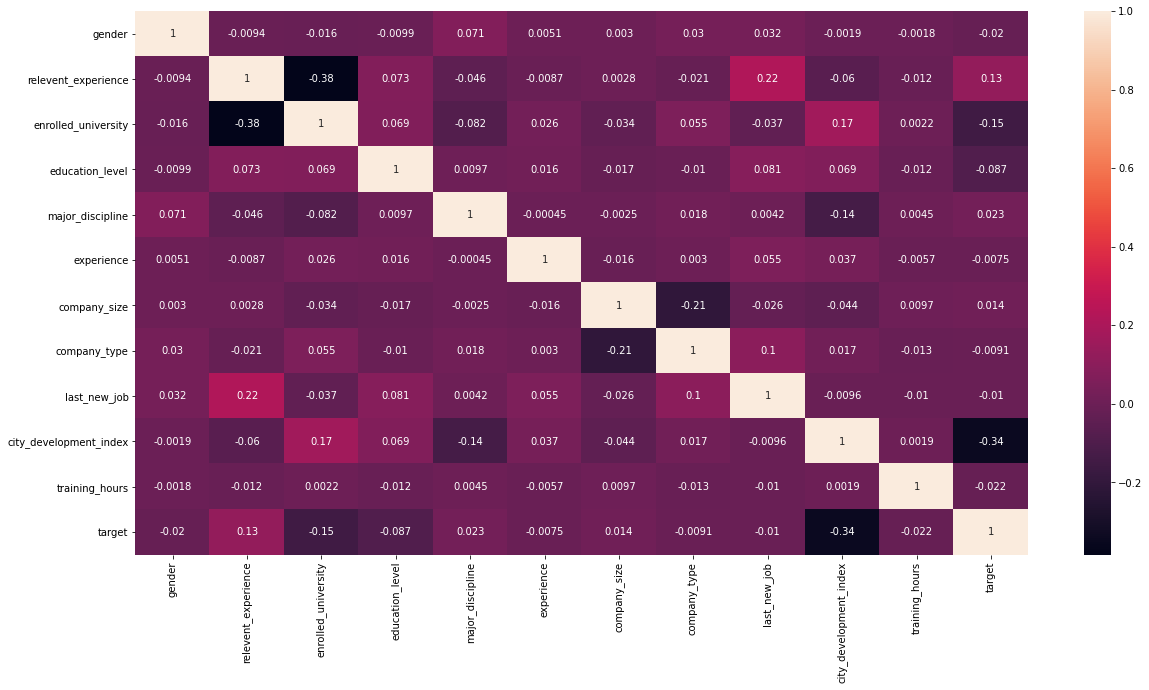

In [ ]:
plt.figure(figsize=(20,10))
sns.heatmap(cleaned_train.corr(),annot = True)

#Dividing into X and y and standardizing the data

In [5]:
X = cleaned_train.drop('target',1)
y = cleaned_train.target

X_train,X_test,y_train,y_test = tts(X,y,test_size=0.25, random_state=42)

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

#Applying SVM smote

In [6]:
svm_smote = SVMSMOTE(sampling_strategy='minority', random_state=42, k_neighbors=5)
X_svm_smote, y_svm_smote = svm_smote.fit_resample(X,y)

X_train_svm, X_test_svm, y_train_svm, y_test_svm = tts(X_svm_smote,y_svm_smote, test_size=0.25, random_state=42)

sc = StandardScaler()
X_train_svm = sc.fit_transform(X_train_svm)
X_test_svm = sc.transform(X_test_svm)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarni

In [7]:
def evaluate(model, X_test, y_test):
    y_pred = model.predict(X_test)
    errors = abs(y_pred - y_test)
    print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
    print(classification_report(y_test,y_pred))
    print(confusion_matrix(y_test,y_pred))
    print('Test Recall Score = ',recall_score(y_test, y_pred))
    print('Test Precision Score = ',precision_score(y_test, y_pred))
    print('Test F1 score = ', f1_score(y_test,y_pred))

    return evaluate

In [8]:
def train_auc_roc_curve(model, X_test, y_test, X_train, y_train):
  base_fpr,base_tpr,base_threshold = roc_curve(y_train, model.predict(X_train))
  plt.plot([0,1])
  plt.plot(base_fpr,base_tpr)
  print("Train auc score :",auc(base_fpr,base_tpr))
  

  return train_auc_roc_curve

In [9]:
def test_auc_roc_curve(model, X_test, y_test, X_train, y_train):
  test_base_fpr,test_base_tpr,test_base_threshold = roc_curve(y_test, model.predict(X_test))
  plt.plot([0,1])
  plt.plot(test_base_fpr,test_base_tpr)
  print("Test auc score :",auc(test_base_fpr,test_base_tpr))
  

  return test_auc_roc_curve

#Model Implementation

In [ ]:
easy = EasyEnsembleClassifier(random_state=42)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarni

Average Error: 0.0978 degrees.
              precision    recall  f1-score   support

         0.0       0.90      0.91      0.90      3603
         1.0       0.91      0.89      0.90      3588

    accuracy                           0.90      7191
   macro avg       0.90      0.90      0.90      7191
weighted avg       0.90      0.90      0.90      7191

[[3283  320]
 [ 383 3205]]
Test Recall Score =  0.8932552954292085
Test Precision Score =  0.9092198581560283
Test F1 score =  0.9011668775481512
              precision    recall  f1-score   support

         0.0       0.91      0.93      0.92     10778
         1.0       0.93      0.91      0.92     10793

    accuracy                           0.92     21571
   macro avg       0.92      0.92      0.92     21571
weighted avg       0.92      0.92      0.92     21571

[[9987  791]
 [ 942 9851]]
Train Recall Score =  0.9127212081904938
Train Precision Score =  0.9256718661905656
Train f1 score = 0.9191509213902496
Train auc score : 0.9

<function __main__.test_auc_roc_curve>

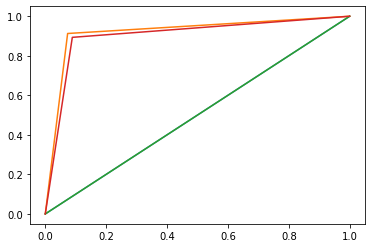

In [11]:
easy = EasyEnsembleClassifier(base_estimator=LGBMClassifier(random_state=42), random_state=42, replacement=True)
easy.fit(X_train_svm, y_train_svm)
evaluate(easy, X_test_svm, y_test_svm)
print("=======================================================================")

print(classification_report(y_train_svm, easy.predict(X_train_svm)))
print(confusion_matrix(y_train_svm, easy.predict(X_train_svm)))
print('Train Recall Score = ',recall_score(y_train_svm, easy.predict(X_train_svm)))
print('Train Precision Score = ',precision_score(y_train_svm, easy.predict(X_train_svm)))
print("Train f1 score =", f1_score(y_train_svm, easy.predict(X_train_svm)))
print("=======================================================================")

train_auc_roc_curve(easy, X_test_svm, y_test_svm, X_train_svm, y_train_svm)
print("=======================================================================")

test_auc_roc_curve(easy, X_test_svm, y_test_svm, X_train_svm, y_train_svm)

In [12]:
predict_probablity = pd.DataFrame(easy.predict_proba(X_test_svm))  #Predicting Probablity

y_pred = easy.predict(X_test_svm)   #Just predicting the outcome as 1 or 0

threshold = 0.5
prediction = np.where(y_pred>threshold,'Will join the company','Will not join the company')

prediction = prediction.T.reshape(-1,1)
prediction = pd.DataFrame(prediction, columns=['Decision'])

prediction = prediction.join(predict_probablity, lsuffix='_right', rsuffix='_left')
prediction = prediction.rename({0 : 'Probablity of not joining', 1 : 'Probablity of joining'}, axis=1)

prediction.head(10)

,Decision,Probablity of not joining,Probablity of joining
0,Will join the company,0.014238,0.985762
1,Will not join the company,0.883258,0.116742
2,Will not join the company,0.971935,0.028065
3,Will join the company,0.147396,0.852604
4,Will join the company,0.001590,0.998410
5,Will not join the company,0.887257,0.112743
6,Will not join the company,0.736079,0.263921
7,Will join the company,0.004034,0.995966
8,Will not join the company,0.669011,0.330989
9,Will join the company,0.354102,0.645898


In [16]:
eli5_permutation = PermutationImportance(estimator = easy, scoring = 'f1', random_state=42, n_iter = 5)
eli5_permutation.fit(X_test_svm, y_test_svm)

PermutationImportance(cv='prefit',
                      estimator=EasyEnsembleClassifier(base_estimator=LGBMClassifier(boosting_type='gbdt',
                                                                                     class_weight=None,
                                                                                     colsample_bytree=1.0,
                                                                                     importance_type='split',
                                                                                     learning_rate=0.1,
                                                                                     max_depth=-1,
                                                                                     min_child_samples=20,
                                                                                     min_child_weight=0.001,
                                                                                     min_split_gain=0.0,
             

In [17]:
feature_importance_with_eli5=pd.DataFrame(np.hstack((np.array([X.columns[0:]]).T, eli5_permutation.feature_importances_.T.reshape(-1,1))), columns=['feature', 'importance'])
feature_importance_with_eli5['importance']=pd.to_numeric(feature_importance_with_eli5['importance'])
feature_importance_with_eli5.sort_values(by='importance', ascending=False)

,feature,importance
0,gender,0.119302
9,city_development_index,0.082364
7,company_type,0.025889
6,company_size,0.022595
1,relevent_experience,0.021471
4,major_discipline,0.019768
3,education_level,0.018065
8,last_new_job,0.011628
5,experience,0.004086
2,enrolled_university,0.002658


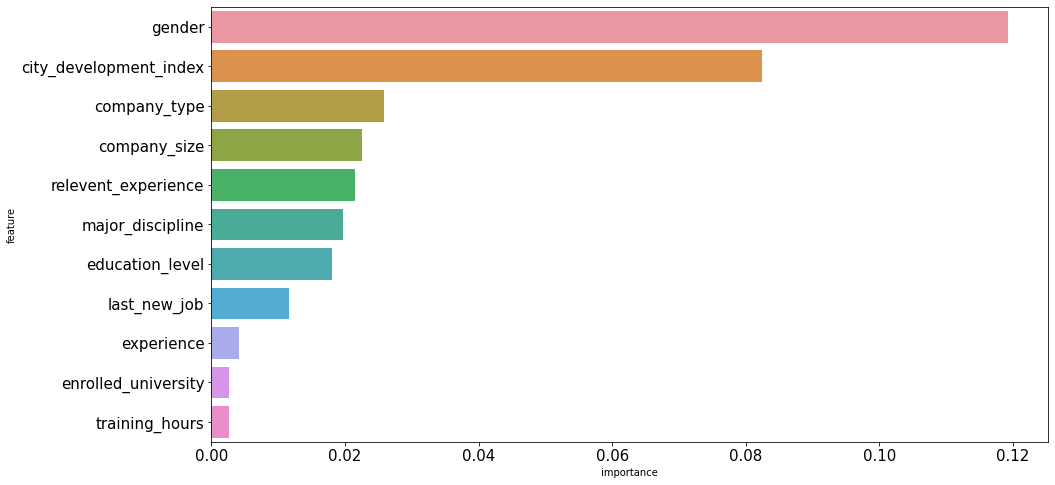

In [18]:
plt.figure(figsize = (15,8))
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
# We sort by importance and get the features
sns.barplot(x = 'importance', y = 'feature', data = feature_importance_with_eli5, 
            order = feature_importance_with_eli5.sort_values('importance', ascending=False).feature) 

#Test Data

In [34]:
missing_values = ["n/a", "na", "--", "NONE", "None", "none", "NA", "N/A",'inf','-inf', '?', 'Null', 'NULL']
test_data = pd.read_csv('aug_test.csv', na_values= missing_values)
test_data.drop(['enrollee_id', 'city'], 1, inplace=True)
test_data.head()

,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours
0,0.827,Male,Has relevent experience,Full time course,Graduate,STEM,9,<10,NaN,1,21
1,0.920,Female,Has relevent experience,no_enrollment,Graduate,STEM,5,NaN,Pvt Ltd,1,98
2,0.624,Male,No relevent experience,no_enrollment,High School,NaN,<1,NaN,Pvt Ltd,never,15
3,0.827,Male,Has relevent experience,no_enrollment,Masters,STEM,11,10/49,Pvt Ltd,1,39
4,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,10000+,Pvt Ltd,>4,72


In [ ]:
test_data.isnull().sum()

city_development_index      0
gender                    508
relevent_experience         0
enrolled_university        31
education_level            52
major_discipline          312
experience                  5
company_size              622
company_type              634
last_new_job               40
training_hours              0
dtype: int64

In [ ]:
test_data.last_new_job.value_counts()

1        884
>4       353
2        342
never    258
3        133
4        119
Name: last_new_job, dtype: int64

In [35]:
test_data['company_size'] = test_data['company_size'].replace('10/49', np.nan)

In [21]:
test_data.company_size.value_counts()

50-99        338
100-500      318
10000+       217
<10          163
1000-4999    143
500-999       88
5000-9999     68
Name: company_size, dtype: int64

In [36]:
to_LabelEncode_test = test_data[['gender', 'relevent_experience',
       'enrolled_university', 'education_level', 'major_discipline',
       'experience', 'company_size', 'company_type', 'last_new_job']]

test_temp = to_LabelEncode_test.astype("str").apply(le.fit_transform)
test_final = test_temp.where(~to_LabelEncode_test.isna(), to_LabelEncode_test)

In [37]:
test_data.drop(['gender', 'relevent_experience','enrolled_university', 'education_level', 'major_discipline','experience', 'company_size', 'company_type', 'last_new_job'],1,inplace=True)

In [ ]:
test_data

,city_development_index,training_hours
0,0.827,21
1,0.920,98
2,0.624,15
3,0.827,39
4,0.920,72
...,...,...
2124,0.920,15
2125,0.897,30
2126,0.887,18
2127,0.804,84


In [38]:
test_data = test_final.join(test_data)

In [ ]:
test_data

,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,city_development_index,training_hours
0,1,0,0,0,5,19,6,NaN,0,0.827,21
1,0,0,3,0,5,15,NaN,5,0,0.920,98
2,1,1,3,1,NaN,20,NaN,5,6,0.624,15
3,1,0,3,2,5,2,NaN,5,0,0.827,39
4,1,0,3,0,5,21,2,5,4,0.920,72
...,...,...,...,...,...,...,...,...,...,...,...
2124,1,1,3,0,2,7,NaN,4,3,0.920,15
2125,1,0,3,2,5,9,NaN,NaN,1,0.897,30
2126,1,1,3,4,NaN,13,NaN,5,6,0.887,18
2127,1,0,0,1,NaN,17,0,4,0,0.804,84


In [43]:
mice_imputer = IterativeImputer(random_state=42, estimator=lr, max_iter=10, n_nearest_features=2, imputation_order = 'roman')
cleaned_test = mice_imputer.fit_transform(test_data)

cleaned_test = pd.DataFrame(cleaned_test)
cleaned_test.columns = ['gender', 'relevent_experience', 'enrolled_university', 'education_level', 'major_discipline',
                                                         'experience', 'company_size', 'company_type', 'last_new_job', 'city_development_index', 'training_hours']
                                                        
cleaned_test

/usr/local/lib/python3.7/dist-packages/sklearn/impute/_iterative.py:638: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)


,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,city_development_index,training_hours
0,1.0,0.0,0.0,0.0,5.000000,19.0,6.000000,4.044265,0.0,0.827,21.0
1,0.0,0.0,3.0,0.0,5.000000,15.0,2.346937,5.000000,0.0,0.920,98.0
2,1.0,1.0,3.0,1.0,4.673732,20.0,2.441230,5.000000,6.0,0.624,15.0
3,1.0,0.0,3.0,2.0,5.000000,2.0,2.397268,5.000000,0.0,0.827,39.0
4,1.0,0.0,3.0,0.0,5.000000,21.0,2.000000,5.000000,4.0,0.920,72.0
...,...,...,...,...,...,...,...,...,...,...,...
2124,1.0,1.0,3.0,0.0,2.000000,7.0,2.485192,4.000000,3.0,0.920,15.0
2125,1.0,0.0,3.0,2.0,5.000000,9.0,2.397268,4.253272,1.0,0.897,30.0
2126,1.0,1.0,3.0,4.0,4.700745,13.0,2.309345,5.000000,6.0,0.887,18.0
2127,1.0,0.0,0.0,1.0,4.741952,17.0,0.000000,4.000000,0.0,0.804,84.0


In [44]:
cleaned_test.isnull().sum()

gender                    0
relevent_experience       0
enrolled_university       0
education_level           0
major_discipline          0
experience                0
company_size              0
company_type              0
last_new_job              0
city_development_index    0
training_hours            0
dtype: int64

In [ ]:
cleaned_test.to_csv('final_test_data.csv', index=False)

In [45]:
final_test_data = pd.read_csv('final_test_data.csv')
final_test_data.head()

,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,city_development_index,training_hours
0,1.0,0.0,0.0,0.0,5.000000,19.0,7.000000,4.374017,0.0,0.827,21.0
1,0.0,0.0,3.0,0.0,5.000000,15.0,3.038146,5.000000,0.0,0.920,98.0
2,1.0,1.0,3.0,1.0,4.648174,20.0,3.144974,5.000000,6.0,0.624,15.0
3,1.0,0.0,3.0,2.0,5.000000,2.0,0.000000,5.000000,0.0,0.827,39.0
4,1.0,0.0,3.0,0.0,5.000000,21.0,3.000000,5.000000,4.0,0.920,72.0


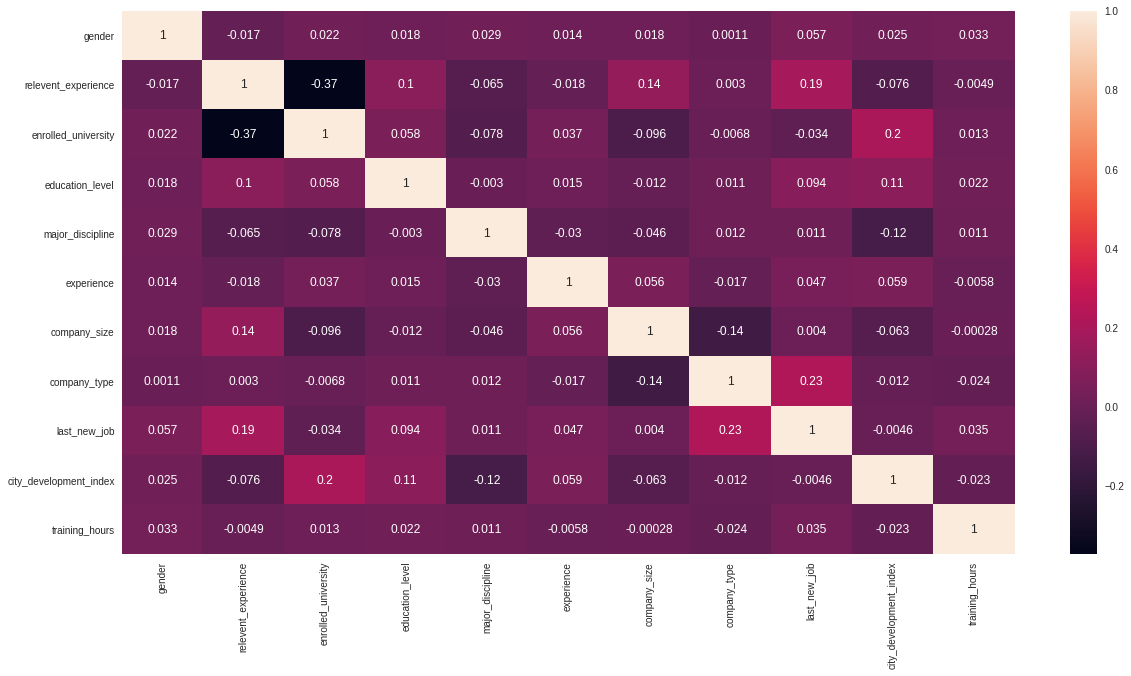

In [ ]:
plt.figure(figsize=(20,10))
sns.heatmap(final_test_data.corr(),annot = True)

In [46]:
final_test_data = sc.transform(final_test_data)

In [ ]:
easy.predict_proba(final_test_data)

array([[0.4851188 , 0.5148812 ],
       [0.84591428, 0.15408572],
       [0.14146669, 0.85853331],
       ...,
       [0.89300949, 0.10699051],
       [0.73171479, 0.26828521],
       [0.90664846, 0.09335154]])

In [48]:
test_prediction = pd.DataFrame(easy.predict(final_test_data))
prediction.value_counts()

threshold = 0.5
my_pred = np.where(test_prediction>threshold,'Will join the company','Will not join the company')

my_pred = my_pred.T.reshape(-1,1)
my_pred = pd.DataFrame(my_pred, columns=['Decision'])

my_pred = my_pred.join(pd.DataFrame(easy.predict_proba(final_test_data)), lsuffix='_right', rsuffix='_left')
my_pred = my_pred.rename({0 : 'Probablity of not joining', 1 : 'Probablity of joining'}, axis=1)
my_pred

,Decision,Probablity of not joining,Probablity of joining
0,Will join the company,0.449612,0.550388
1,Will not join the company,0.853942,0.146058
2,Will join the company,0.126449,0.873551
3,Will not join the company,0.911890,0.088110
4,Will not join the company,0.927860,0.072140
...,...,...,...
2124,Will not join the company,0.777469,0.222531
2125,Will join the company,0.198974,0.801026
2126,Will not join the company,0.908740,0.091260
2127,Will not join the company,0.710569,0.289431
